In [3]:
import numpy as np
import matplotlib.pyplot as plt

figure_width = 9
plt.rcParams['figure.figsize'] = [figure_width, figure_width * 3/8]
plt.rcParams['figure.dpi'] = 90
plt.rcParams['legend.fontsize'] = 'large'

# Envelope Generation, a Virtual Analog Approach

<img src="_nb_images/rc_circuit.png" alt="Drawing" style="width: 500px;"/>

You might recognize this humble circuit as a classic example in any undergraduate physics, circuits, or differential equations course. It's also the circuit at the heart of analog envelope generation. It's a simplified model of a charging capacitor, which has some voltage $V_C = V_0$, and at time $t_0$, we suddenly apply a new voltage $V_1$. The resistor controls how quickly the capacitor is charged, since it limits the current that charges it. Higher resistances charge the capacitor more slowly. The surrounding circuitry you'll find in an analog envelope generator is mainly the logic and buffering required to charge and discharge the capacitor to specific voltages in response to control signals.

### Basic Requirements
To model the circuit, what we're after is $V_C(t)$, that is, some expression for the voltage across the capacitor as a function of time. From experience with envelope generators or some rudimentary knowledge of electronics, we might expect the voltage to rise logarithmically and fall exponentially. 

At the bare minimum, our goal is to use this expression to compute samples of voltage curves in a way that allows us to specify:

1. Some duration in seconds $T$, which defines the time interval $[t_0, t_1]$ as $[0, T]$
2. Some initial voltage on the capacitor $V_C(0) = V_0$
3. Some final voltage on the capacitor $V_C(T) = V_1$

Some examples of our boundary conditions in an envelope generator might be an attack curve that starts at $V_0 = 0$ and rises to $V_1 = 1$, a decay curve that falls from $1$ to some sustain level $V_{sus}$, or a relase curve that falls from $V_{sus}$ to $0$. 

With any familiarity with differential equations, you might have already recognized this as a boundary value problem, since we'll to have to constrain our $V_C(t)$ function to pass through specific initial and final values. A differential equation for $V_C(t)$ would incorporate both a proportional term $V_C$ and its time derivative $\frac{dV_C}{dt}$. We'll use two pieces of information about the physics of the capacitor and circuit theory to obtain this differential equation.

### Capacitor Physics
Starting from the basic physical principles of a cacpacitor, we know its purpose is to store energy in an electric field. It does so by accumulating charges on parallel plates separated by a dialectric that prevents electrons from flowing between plates. The capacitor's voltage is proportional to the amount of charge $Q_C$ accumulated

$$V_C = \frac{Q_C}{C}$$

Even though DC is blocked by the dialectric, AC can still pass between plates. This is because each electron discharged from one plate causes an electron to accumulate on the opposite plate, and vice versa&mdash;that is, current only flows when the amount of charge is changing. Formally, this means that the rate of electrons seen coming into or going out of either terminal of the capacitor (the current) is proportional to the first time derivative of charge. We can therefore express the current in terms of the change in voltage

$$i_C(t) = \frac{dQ_C}{dt} = C \cdot \frac{dV_C}{dt}$$

### Kirchhoff's Voltage Law
So we've got a derivative term, and we can use Kirchoff's Voltage Law to incorporate the proportional term. KVL describes how the voltage source $V_1$ gets distributed across the series-connected R and C

$$V_1 = V_R + V_C$$

Noting that the series connection means that the same current flows through both the resistor and capacitor, we can use Ohm's law to express the resistor's voltage drop in terms of the shared current $i_C(t)$

$$V_1 = RC\frac{dV_c}{dt} + V_C$$

Since we've got a separable differential equation, we can rearrange so that we have the $t$ and $V_C$ dependencies on opposite sides, then we integrate to obtain an implicit solution

$$(V_1 - V_C)\frac{1}{dV_C} = RC\frac{1}{dt}$$
.
$$\int{(V_1 - V_C)\frac{1}{dV_C}} = \int{RC\frac{1}{dt}}$$
.
$$-ln(V_1 - V_C) = \frac{1}{RC}t + c_0$$

### Boundary Values
From here, incorporating the initial condition $V_C(0)$ would give us the explicit solution. Whereas we could set the initial condition to compute attacks from $0$, or decays from $1$, we might want our envelope generator to be able to retrigger an attack without having to start over from $0$, or if our gate signal goes low during an attack or decay, we may want to generate a release ramp from whatever the current $V_C$ is instead of fixing it to release from $V_{sus}$. Regardless, it's often more enlightening to generalize to see if we can cover all our boundary conditions anyway, so we can parameterize the initial voltage $V_C(0) = V_0$, and use the above equation to obtain the constant $c_0 = -ln(V_1-V_0)$.

We can then plug our integration constant back in and solve for $V_C$

$$-ln(V_1 - V_C) = t\frac{1}{RC} -ln(V_1-V_0)$$
.
$$V_1 - V_C = e^{-t\frac{1}{RC}} (V_1 - V_C)$$
.
$$V_C(t) = V_1(1 - e^{-t\frac{1}{RC}}) + V_0 e^{-t\frac{1}{RC}}$$

You might recognize the term $e^{-t\frac{1}{RC}}$ as a decaying exponential curve which starts at $1$ at $t = 0$, and asymptotically approaches $0$. 

Consequently, $(1 - e^{-t\frac{1}{RC}})$ is an increasing logarithmic curve starting at $0$ and asymptotically approaching $1$. 

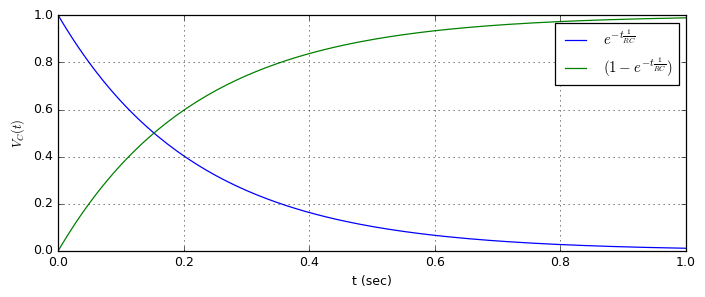

In [847]:
tt = np.linspace(0, 1, 128)     # Time interval (sec)
C = 100e-6    # 100uF
R = 2.2e3     # 2.2k

exp_curve = np.exp(-tt / (R*C))  
log_curve = (1 - exp_curve)

plt.plot(tt, exp_curve, label=r'$e^{-t\frac{1}{RC}}$')
plt.plot(tt, log_curve, label=r'$(1 - e^{-t\frac{1}{RC}})$')

plt.ylabel('$V_C(t)$')
plt.xlabel('t (sec)')
plt.legend()
plt.grid()
plt.show()

With these two pieces of intuition, we can think of $V_C(t)$ as a crossfade between $V_0$ and $V_1$, where the initial voltage is faded out exponentially while a target voltage is faded in logarithmically.

This generalization means we don't actually have to repeat the derivation for the discharing capacitor case. The ramp will just be a logarithmic attack if we use $V_0 < V_1$ or an exponential decay if $V_0 > V_1$. 

## Ramp Duration

The rate at which the curves approach their target values is determined by the time constant $\tau = RC$. A simple analog envelope generator could vary the time constant by fixing $C$ and substituting a variable resistor for $R$. Doing this virtually, we can just control the duration of attacks and decays using tau.

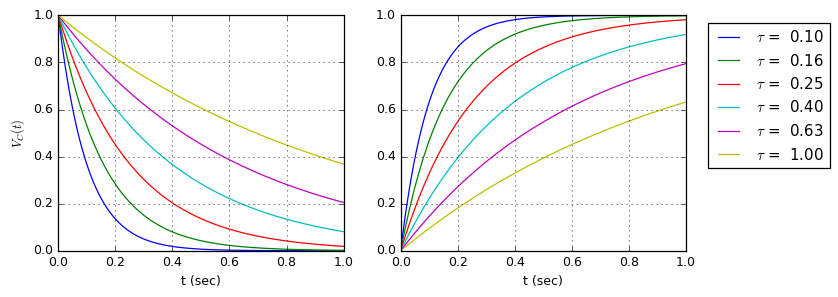

In [848]:
tt = np.linspace(0, 1, 128)    # Time interval (sec)

# Plot falling and rising curves for varying time constant
tau = np.logspace(-1, 0, 6)    

fig, ax = plt.subplots(1, 2)
for n in range(len(tau)):
    dec_ramp = np.exp(-tt / tau[n])
    atk_ramp = 1 - np.exp(-tt / tau[n])
    ax[0].plot(tt, dec_ramp, label='$\\tau$ = %5.2f' % tau[n])
    ax[1].plot(tt, atk_ramp, label='$\\tau$ = %5.2f' % tau[n])
    
ax[0].set_ylabel('$V_C(t)$')
ax[0].set_xlabel('t (sec)')
ax[1].set_xlabel('t (sec)')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2)
ax[0].grid()
ax[1].grid()
plt.show()

If we're designing an analog circuit, we can get away with trying a bunch of pot values until we get roughly the time range we want, but there's no reason not to make our virtual ramps take the exact durations we specify. 

Though the fact that we never actually reach our target voltage&mdash;only approaching it asymptotically&mdash;complicates things slightly, we can use a workaround borrowed from analog envelope generators. Namely, we'll charge the capacitor with a voltage source that's higher than our actual target voltage by some amount $\epsilon$ and end our state when the capacitor voltage reaches the target voltage. 

This means we have to find the time constant $\tau$ that yields a logarithmic crossfade between $V_0$ and $V_1 + \epsilon$ such that $V_C(t_1) = V_1$

$$V_C(t_1) = V_1 = (V_1 + \epsilon)(1 - e^{-t_1\frac{1}{\tau}}) + V_0 e^{-t_1\frac{1}{\tau}}$$
.
$$\tau = \frac{-t_1}{ln\left(\frac{\epsilon}{V_1 - V_0 + \epsilon}\right)}$$

Similarly, for the discharge case, we're aiming below the level we actually want, which means we need to find a time constant $\tau$ that yields a logarithmic crossfade between $V_0$ and $V_1 - \epsilon$ such that $V_C(t_1) = V_1$

$$V_C(t_1) = V_1 = (V_1 - \epsilon)(1 - e^{-t_1\frac{1}{\tau}}) + V_0 e^{-t_1\frac{1}{\tau}}$$
.
$$\tau = \frac{-t_1}{ln\left(\frac{\epsilon}{V_0 - V_1 + \epsilon}\right)}$$

Assuming $V_0 < V_1$ in the charging case, and $V_0 > V_1$ in the discharging case, notice we can substitute the range $\left|V_1 - V_0\right|$, since it's positive in either case

$$\tau = \frac{-t_1}{ln\left(\frac{\epsilon}{\left|V_1 - V_0\right| + \epsilon}\right)}$$

## Shape Control

Incidentally, our workaround that was necessary just to get ramps of finite duration ends up giving us the ability to continuously vary shape between logarithmic and linear for rising ramps, and between exponential and linear for falling ramps. Higher values of our overshoot parameter $\epsilon$ make for more linear ramps, which should make some intuitive sense because if we aim way above our desired voltage and truncate when we reach it, then we end up using only a small linear section of the full trajectory.

Here we use a range of $\epsilon$ values from $0.01$ through $1$, spaced logarithmically, which gives a good uniform spacing between curve knees.

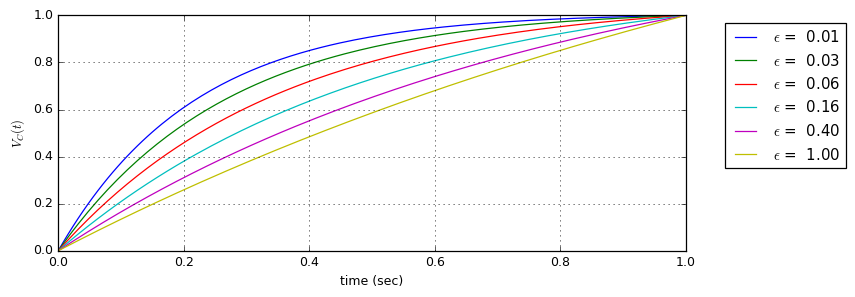

In [956]:
v0 = 0  # Initial voltage
v1 = 1  # End voltage
T = 1   # Ramp duration (sec)
t0, t1 = 0, T   # Time bounds
tt = np.linspace(t0, t1, 128)     

# Plot rising curves for varying overshoot amount (epsilon)
eps = np.logspace(-2, 0, 6)     
for n in range(len(eps)):
    tau = -t1 / np.log((eps[n] / (abs(v1 - v0) + eps[n])))
    exp_term = np.exp(-tt / tau)
    ramp = v0 * exp_term + (v1 + eps[n]) * (1 - exp_term)
    plt.plot(tt, ramp, label='$\\epsilon$ = %5.2f' % eps[n])
    
plt.xlabel('time (sec)')
plt.ylabel('$V_C(t)$')
plt.ylim((0, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

And the same goes for the falling ramp case, where we 'undershoot' our actual target voltage

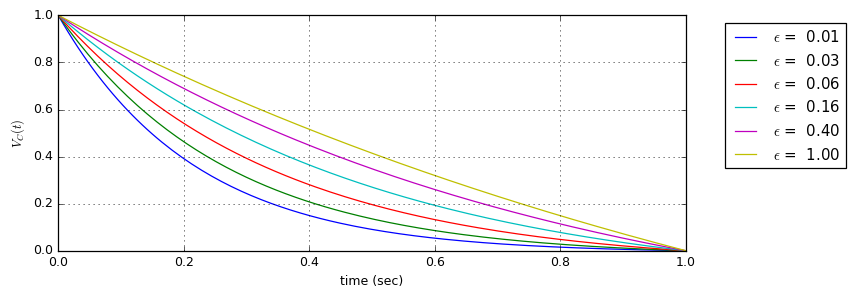

In [957]:
v0 = 1  # Initial voltage
v1 = 0  # End voltage
t1 = 1  # End time (sec)
tt = np.linspace(0, t1, 128)     

# Plot falling curves for varying overshoot amount (epsilon)
eps = np.logspace(-2, 0, 6)    
for n in range(len(eps)):
    tau = -t1 / np.log((eps[n] / (abs(v1 - v0) + eps[n])))
    exp_term = np.exp(-tt / tau)
    ramp = v0 * exp_term + (v1 - eps[n]) * (1 - exp_term)
    plt.plot(tt, ramp, label='$\\epsilon$ = %5.2f' % eps[n])
    
plt.xlabel('time (sec)')
plt.ylabel('$V_C(t)$')
plt.ylim((0, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

# Real Time

*Note: If real time is completely new to you or if this section feels like it's skipping some detail, I highly recommend checking out the derivation of a [linear envelope generator](linear.ipynb), which uses the same structure as this example and motivates the design choices.*

Now that we've played with the math a bit, our an envelope generator implementation should be suitable for real-time sample rendering, meaning it needs to efficiently

1. Compute and return the next sample
1. Maintain a state for each ramp 
1. Implement logic for switching between states `attack`, `decay`, `sustain`, `release`, and `idle`
1. Modify durations, shapes, and bounds of each ramp&mdash;including any time during the ramp we're modifying

So we need a state machine, and we need to consider which parts of the relevant equations are changing when we update our parameters or render samples so that we can avoid redundant computation, especially if we're running on a resource constrained embedded platform. The C++ implementation is provided, and you'll find the object-oriented Python prototype following some additional derivations below.

As in the linear example, we're of course using discrete time, which means the following derivations replace all the $t$s with the sample index $n$ (called `phase` in the implementation), and all our $T$s with an integer-valued $length$. 

## Division of Labor

Of all the things our envelope generator needs to do, we'll start with rendering an output sample, since it happens most often. We'll also just consider an attack for now, so recall the output is a crossfade between bounds $V_0$ and $V_1 + \epsilon$

$$V_C[n] = (V_1 + \epsilon)(1 - e^{-n\frac{1}{\tau}}) + V_0 e^{-n\frac{1}{\tau}}$$

Our bounds don't depend on $n$, so there's no need to evaluate those every sample. What we do need to evaluate is the decaying exponential $V_{exp} = e^{-n\frac{1}{\tau}}$, but it would be an egregious waste to evaluate $V_{exp}$ on every sample in this instance. We don't need to jump to the $n$th sample at will, we just need to know how to get from the current sample to the next sample. 

### 1. Unrolling the Decaying Exponential

Given we're working in discrete time, observe that the value of our exponential term any given sample, can be expressed as

$$V_{exp}[n] = e^\frac{-n}{\tau} = \prod_{i=0}^{n} e^\frac{-1}{\tau}$$

which means we can initialize $V_{exp}$ to $1$ when we begin a state, and in the render method, multiply it by the coefficient $e^\frac{-1}{\tau}$, which we will have precomputed.  That's a reduction to one multiplication what would have taken a division and a call to an exponential function.

Next, we could take a look at the coefficient and its dependency on $\tau$. Recall it depends on $\epsilon$, $L$, and the range $V_1 - V_0$. 

$$\tau = \frac{-L}{ln\left(\frac{\epsilon}{V_1 - V_0 + \epsilon}\right)}$$
.
$$c_{exp} = e^{-\frac{1}{\tau}} = exp\left\{\frac{1}{L} ln\left(\frac{\epsilon}{V_1 - V_0 + \epsilon}\right)\right\}$$

In the derivation, we generalized $V_0$ so that we could begin a ramp at whatever the current level is. This flexibility unfortunately meant that we would need to recompute the coefficient every time we started a new state, even if neither the shape nor length had changed.  

Consider the case of our ADSR configured as an oscillator&mdash;we set a flag that transitions `release` directly back to `attack`, rather than `idle`. Now we're repeatedly computing the same three coefficients for `a/d/r`, and we're doing it at three times the rate of the oscillator. Moreover, we're making relatively expensive calls to `log()` and `exp()` each time. 

That's a ton of redundant computation, and sure we can just store the previous coefficient and reuse it, but that would require a bunch of extra variables and conditionals&mdash;ugly code, especially if we could just generalize the math instead. If it were possible to remove the dependency of the coefficient on the bounds, it would be unnecessary to recompute the coefficient until shape or length changes.

### 2. Decoupling Bounds from Shape and Length

I can't say that I really had a good derivation for this, only a feeling that it should be possible to normalize the range in the exponential term to $1$, since we're really just crossfading two values using a curve of our specified length and shape. It seemed like it should be possible to nudge the bounds of the crossfade to correct for the normalization, then we'd only need to update the coefficient for changes in length or shape.

After the first version was functional, I started by normalizing

$$c_{exp} = exp\left\{ \frac{1}{L} ln\left( \frac{\epsilon}{1 + \epsilon} \right) \right\}$$

and without modifying the bounds $V_T = V_1 + \epsilon$ and $V_0$ in the $V_C[n]$ equation, I observed that curves sticking to the $[0, 1]$ interval aligned nicely (of course), while using smaller ranges would cause rising curves to overshoot, and falling curves to undershoot their destinations.

Playing with the parameters of an attack, I noticed that reducing $V_1$, thus reducing the range, increased the error. I noticed that larger $\epsilon$ values yielded larger errors as well. With a shot in the dark, I tried scaling the contribution of the overshoot parameter $\epsilon$ to the target voltage by the range of the interval, and it ended up playing nicely with the normalized $V_{exp}$ ramp

$$V_T = V_1 + \epsilon \cdot (V_1 - V_0)$$

It's also independent of whether we're rising or falling and allows us to eliminate the absolute value, because multiplication with a falling ramp scales $\epsilon$ by the negative of the range, so we're overshooting when we're supposed to, and undershooting when we're supposed to.

Despite my inability to prove why this works mathematically, this modification produces exactly the same values as before while obviating recomputing the coefficient. So all we have to compute to initialize a state's ramp is a simple assignment for the lower bound, and for the upper bound, an addition, a subtraction, and a mulitplication. I'd be very interested to see a derivation of this if anyone can work it out!

### 3. Eliminating `exp()` and `log()`

Finally, there's one last easy modification of the coefficient equation that may significantly speed up the calculation of the coefficient (but it depends). Note a property of exponentiation, namely that taking a number to the power of a fraction can be expressed in terms of an $N$th root

$$x^\frac{a}{b} = \sqrt[b]{x^a}$$

Which means we can express the normalized coefficient as

$$c_{exp} = \sqrt[L]{\frac{\epsilon}{1+\epsilon}}$$

This modification allows the coefficient to be computed must faster in Python compared to using `math.exp()` and `math.log()` or their Numpy equivalents. However, execution times for the two versions in C using floating point or double precision implementations of `exp()`, `log()`, and `pow()` may vary considerably using different processors and compilers. The bottom line is that it behooves you to test it on your platform.

## Summary of Steps

For any state, whenever there is a change in the shape $\epsilon$, or the ramp length $L$, we compute the normalized coefficient

$$c_{exp} = \sqrt[L]{\frac{\epsilon}{1+\epsilon}}$$

When the bounds $V_0$, $V_1$ change, such as at the beginning of a state or if the sustain level is modified during `decay`, we set the lower bound to the new specification and compute the new upper bound

$$V_T = V_1 + \epsilon \cdot (V_1 - V_0)$$

Whenever we need to render a sample, we can apply the current state's coefficient to update the exponential decay term

$$V_{exp} := V_{exp} \cdot c_{exp}$$

Then we can compute our output voltage
$$V_C = V_T \cdot (1 - V_{exp}) + V_0 \cdot V_{exp}$$

Below, you can see where these equations are used in the functions `__compute_coeff()`, `__init_ramp()`, and `render()`, respectively.

### *Note on recomputing coefficients mid-state*
Bear in mind that in this case, setting state length or shape while we're in the middle of the state will incur just over twice the cost, since we need to compute a coefficient for the newly-specified parameters, *and* we need to compute a temporary coefficient and initialize bounds used for the remainder of the state. 

This issue didn't arise in the linear envelope generator because our slope computation was so cheap, we were content to just compute it at the beginning of each state. However, rest assured that we can ultimately compute these curves efficiently enough so that this isn't a major concern.

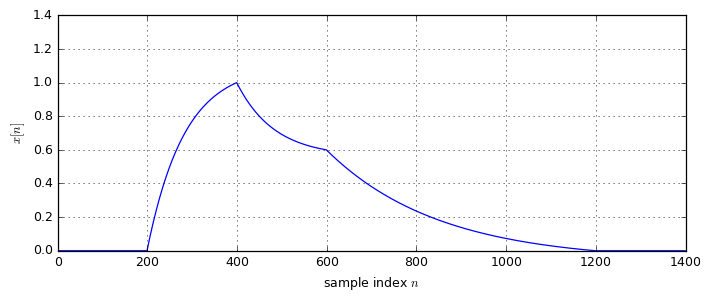

In [4]:
class ADSR:
    
    def __init__(self, atk_len, dec_len, sus_level, rel_len, eps):
        self.__begin_idle()
        self.v_sus = sus_level
        self.set_attack(eps, atk_len)
        self.set_decay(eps, dec_len)
        self.set_release(eps, rel_len)
        self.sustain = False 
        self.retrigger = False
            
    def __compute_coeff(self, eps, length):
        return ((eps / (1 + eps)) ** (1 / length))
        
    def __init_ramp(self, v0, v1, eps, coeff, length):
        self.v_0 = v0
        self.v_T = v1 + eps * (v1 - v0)
        self.length = length
        self.coeff = coeff
        self.v_exp = 1
            
    def __begin_idle(self):
        self.state = 'idle'
        self.v_c = 0
        
    def __begin_attack(self):
        self.state = 'attack'
        self.__init_ramp(self.v_c, 1, self.atk_eps, self.atk_coeff, self.atk_len)
        self.phase = 0
        
    def __begin_decay(self):
        self.state = 'decay'
        self.__init_ramp(self.v_c, self.v_sus, self.dec_eps, self.dec_coeff, self.dec_len)
        self.phase = 0
        
    def __begin_sustain(self):
        self.state = 'sustain'
        self.v_c = self.v_sus
        
    def __begin_release(self):
        self.state = 'release'
        self.__init_ramp(self.v_c, 0, self.rel_eps, self.rel_coeff, self.rel_len)
        self.phase = 0
        
    def __next_state(self):
        if self.state == 'attack':
            self.__begin_decay()
        elif self.state == 'decay':
            if self.sustain:
                self.__begin_sustain()
            else:
                self.__begin_release()
        elif self.state == 'release':
            if self.retrigger:
                self.__begin_attack()
            else:
                self.__begin_idle()
            
    def set_attack(self, eps, length):
        self.atk_len = length
        self.atk_eps = eps
        self.atk_coeff = self.__compute_coeff(eps, length)
        if self.state == 'attack':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.v_c, 1, eps, self.__compute_coeff(eps, length), self.atk_len)
            
    def set_decay(self, eps, length):
        self.dec_len = length
        self.dec_eps = eps
        self.dec_coeff = self.__compute_coeff(eps, length)
        if self.state == 'decay':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.v_c, self.v_sus, eps, self.__compute_coeff(eps, length), self.dec_len)
            
    def set_sustain(self, level):
        self.v_sus = level
        if self.state == 'decay':
            length = self.dec_len - self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.v_c, self.v_sus, self.dec_eps, self.__compute_coeff(self.dec_eps, length), self.dec_len)
        elif self.state == 'sustain':
            self.v_c = self.v_sus
        
    def set_release(self, eps, length):
        self.rel_len = length
        self.rel_eps = eps
        self.rel_coeff = self.__compute_coeff(eps, length)
        if self.state == 'release':
            length -= self.phase
            length = length if length > 1 else 1
            self.__init_ramp(self.v_c, 0, eps, self.__compute_coeff(eps, length), self.rel_len)
        
    def gate(self, is_high):
        if is_high:
            self.__begin_attack()
        else:
            self.__begin_release()
    
    def render(self):
        if self.state == 'idle' or self.state == 'sustain':
            return self.v_c
        self.v_exp *= self.coeff
        self.v_c = self.v_T * (1 - self.v_exp) + self.v_0 * self.v_exp
        self.phase += 1
        if self.phase >= self.length:
            self.__next_state()
        return self.v_c

fs = 1000
adsr = ADSR(int(0.2*fs), # Attack length
            int(0.2*fs), # Decay length
            0.6,         # Sustain level
            int(0.6*fs), # Release length
            0.1)         # Overshoot (shape)
adsr.sustain = False

# Render 1.4 seconds of samples, and save for plotting
render_length = int(1.4 * fs)
cv_out = np.zeros(render_length)   
for n in range(render_length):
    
    # Gate on after 0.2 seconds
    if n == int(0.2 * fs):
        adsr.gate(True)
        
    # Try inserting some parameter changes at different times,
    # to verify that we can modify ramps mid-state

    cv_out[n] = adsr.render()   # Render
    
    # Uncomment to verify the exact values generated
#     print('state = %s, level = %f' % (adsr.state, cv_out[n]))
    
plt.plot(cv_out)
plt.xlabel('sample index $n$')
plt.ylabel('$x[n]$')
plt.ylim((0, 1.4))
plt.grid(True)
plt.show()

Et voila! Pretty nifty, and fairly efficient.

The C++ version inlines almost all the methods for speed, and runs well on a Teensy 3.6 (ARM Cortex M4 with hardware floating point, compiled with ARM-GCC), taking an average of $0.104\mu s$ to render a sample, and $0.0778\mu s$ to compute the coefficient, meaning that we could have very low-latency coupling between our control input and sound, even recomputing the coefficient at audio rate, with plenty of headroom for other computation. 

In this case, there was no significant difference between using `expf()` and `logf()` to compute the coefficient, and using the $N^{th}$ root via `powf()`, indicating perhaps that ARM-GCC computes both in the same way under the hood.

You could, of course make other efficiency tweaks if you don't care about code readability, and you could even try writing the render method in assembly. If you modify this example, make sure to clock it so you know how your modifications affect the efficiency. Be especially careful adding methods that make calls to existing methods, as too many nested inline functions can drastically increase execution times.